In [1]:
%config Application.log_level='INFO'

In [2]:
import heapq
import json
from pathlib import Path
import pickle
import shutil
import numpy as np


import tqdm
from loop_alphapose_training import run_cmd, Iteration
import logging
import coloredlogs
from PIL import Image

In [3]:
from pycocotools.coco import COCO

In [4]:
logger = logging.getLogger(__name__)
coloredlogs.install(level=logging.INFO)

In [5]:
def diff_keypoints(ann1, ann2) -> float:
    if ann1 is None or ann2 is None:
        return None
    return np.linalg.norm(np.array(ann1['keypoints']) - np.array(ann2['keypoints']))


In [6]:
def diff_bbox(bbox1, bbox2) -> float:
    return np.linalg.norm(np.array(bbox1)-np.array(bbox2))


In [7]:
def match_annotations(anns1: list[dict], anns2: list[dict]) -> list[tuple]:
    # both 1 simple case:
    if len(anns1) == 1 and len(anns2) == 1:
        return [(anns1[0], anns2[0])]
    
    if len(anns2) == 0:
        return [(ann1, None) for ann1 in anns1]
    
    if len(anns1) == 0:
        return [(None, ann2) for ann2 in anns2]

    matches = []
    # TODO this loop is biased towards the first item in anns1, idaelly
    # we first calculate the diffs between all annotations, and sort that.
    # but this is quicker and perhaps fine for our purpose
    for ann1 in anns1:
        if len(anns2) == 0: # this can have happended in the loop
            matches.append((ann1, None))
        else:
            diffs = np.array([diff_bbox(ann1['bbox'], ann2['bbox']) for ann2 in anns2])
            match = anns2.pop(diffs.argmin())
            matches.append((ann1, match))
    
    matches.extend([(None, ann2) for ann2 in anns2])
    return matches


In [8]:
original_path = Path('data/coco/annotations/person_keypoints_train2017.json')

coco_orig = COCO(original_path)

loading annotations into memory...
Done (t=6.85s)
creating index...
index created!


In [9]:
def find_most_different_annotations(coco_orig: COCO, iteration: Iteration, n: int = 10) -> tuple[int, float, dict, dict]:
    iteration_path = iteration.merged_results_path('train')
    coco_iter = COCO(iteration_path)
    
    matched_annotations = []
    for img_id, img in tqdm.tqdm(coco_orig.imgs.items()):
        anns_iter = [coco_iter.anns[ann_id] for ann_id in coco_iter.getAnnIds(imgIds = img_id)]
        anns_orig = [coco_orig.anns[ann_id] for ann_id in coco_orig.getAnnIds(imgIds = img_id)]
        matched_annotations.extend([(img_id, ann1, ann2) for ann1, ann2 in match_annotations(anns_orig, anns_iter)])
        
    match_losses = []
    skipped_empty, skipped_kp = 0, 0
    for img_id, ann1, ann2 in tqdm.tqdm(matched_annotations):
        if ann1 is None or ann2 is None:
            # todo: we later want to store these somewhere else
            logger.debug(f'skipping hallucination or removal in {img_id}')
            skipped_empty+=1
            continue
        if ann1['num_keypoints'] < 3:
            logger.debug(f'skipping small number of keypoints in {img_id}')
            skipped_kp+=1
            continue
        match_losses.append((img_id, diff_keypoints(ann1, ann2), ann1, ann2))

    logger.info(f'Skipped {skipped_empty} hallucinations or removals')
    logger.info(f'Skipped {skipped_kp} annotations with small nr of keypoints')

    return heapq.nlargest(n, match_losses, key=lambda ml: ml[1])


In [10]:
def copy_annotation_matches_to_path(path: Path, results: list[int, float, dict, dict]):
    largest_diff_files = [Path('data/coco/train2017/') / coco_orig.imgs[img_id]['file_name'] for img_id, diff, ann1, ann2 in results]

    display(Image.open(largest_diff_files[0]))
    for source in largest_diff_files:
        fn = source.name
        dest = path / fn
        logger.info(f"Copy {source} -> {dest}")
        shutil.copy(source, dest)

loading annotations into memory...
Done (t=10.50s)
creating index...
index created!


100%|██████████| 355665/355665 [00:02<00:00, 134386.96it/s]
2023-03-08 13:21:59 suspicion __main__[3180558] INFO Skipped 104988 hallucinations or removals
2023-03-08 13:21:59 suspicion __main__[3180558] INFO Skipped 111450 annotations with small nr of keypoints


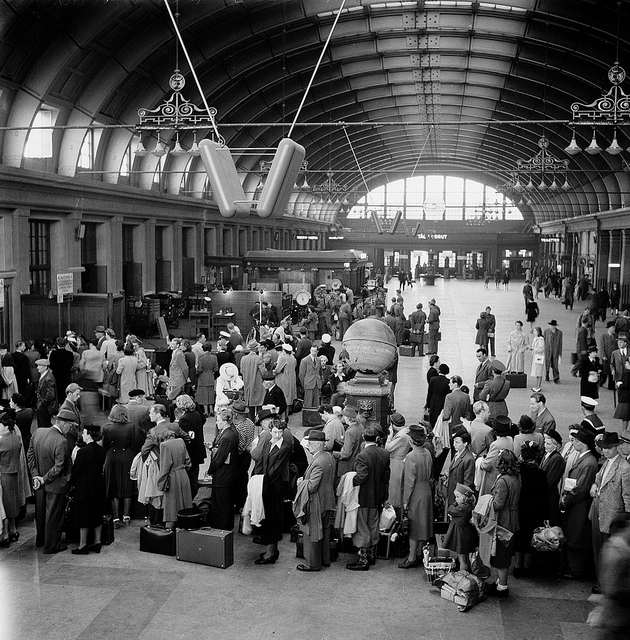

2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000189780.jpg -> data/test_imgs/000000189780.jpg
2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000337976.jpg -> data/test_imgs/000000337976.jpg
2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000006140.jpg -> data/test_imgs/000000006140.jpg
2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225392.jpg -> data/test_imgs/000000225392.jpg
2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225645.jpg -> data/test_imgs/000000225645.jpg
2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000479125.jpg -> data/test_imgs/000000479125.jpg
2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000523173.jpg -> data/test_imgs/000000523173.jpg
2023-03-08 13:22:00 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000543742

loading annotations into memory...
Done (t=9.13s)
creating index...
index created!


100%|██████████| 343354/343354 [00:02<00:00, 131424.31it/s]
2023-03-08 13:22:21 suspicion __main__[3180558] INFO Skipped 97111 hallucinations or removals
2023-03-08 13:22:21 suspicion __main__[3180558] INFO Skipped 108204 annotations with small nr of keypoints


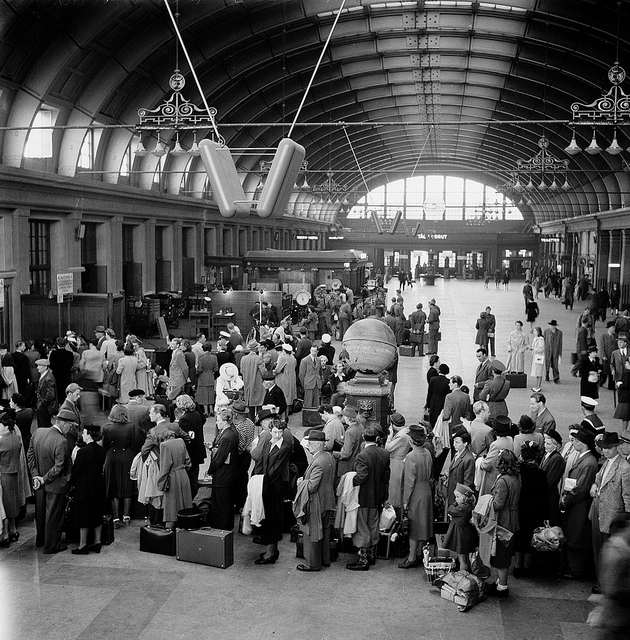

2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000189780.jpg -> data/test_imgs/000000189780.jpg
2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000337976.jpg -> data/test_imgs/000000337976.jpg
2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225645.jpg -> data/test_imgs/000000225645.jpg
2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225392.jpg -> data/test_imgs/000000225392.jpg
2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000008285.jpg -> data/test_imgs/000000008285.jpg
2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000195826.jpg -> data/test_imgs/000000195826.jpg
2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000179926.jpg -> data/test_imgs/000000179926.jpg
2023-03-08 13:22:22 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000045537

loading annotations into memory...
Done (t=8.94s)
creating index...
index created!


100%|██████████| 339755/339755 [00:01<00:00, 248451.97it/s]
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Skipped 100474 hallucinations or removals
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Skipped 105948 annotations with small nr of keypoints


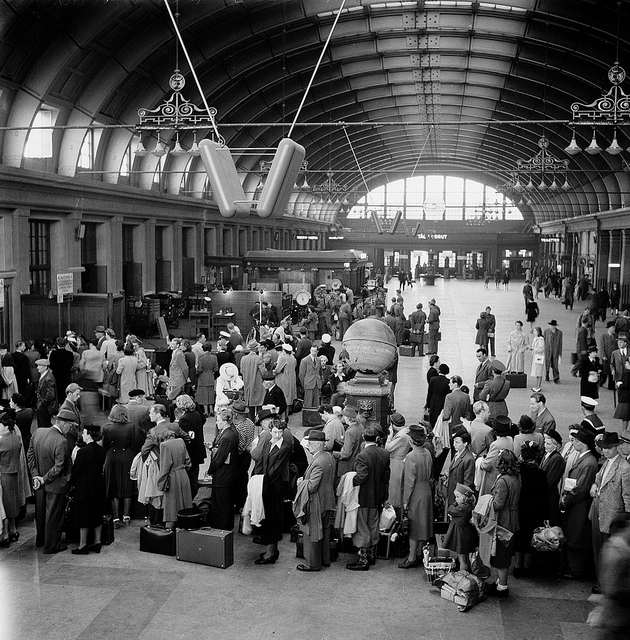

2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000189780.jpg -> data/test_imgs/000000189780.jpg
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000183602.jpg -> data/test_imgs/000000183602.jpg
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225392.jpg -> data/test_imgs/000000225392.jpg
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000179926.jpg -> data/test_imgs/000000179926.jpg
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000045537.jpg -> data/test_imgs/000000045537.jpg
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000479125.jpg -> data/test_imgs/000000479125.jpg
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000410350.jpg -> data/test_imgs/000000410350.jpg
2023-03-08 13:22:42 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000398753

loading annotations into memory...
Done (t=10.16s)
creating index...
index created!


100%|██████████| 342772/342772 [00:01<00:00, 261823.19it/s]
2023-03-08 13:23:03 suspicion __main__[3180558] INFO Skipped 103395 hallucinations or removals
2023-03-08 13:23:03 suspicion __main__[3180558] INFO Skipped 106622 annotations with small nr of keypoints


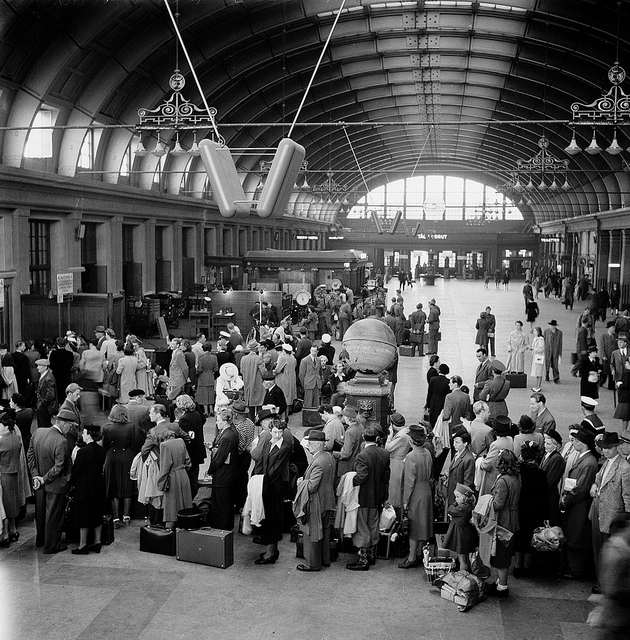

2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000189780.jpg -> data/test_imgs/000000189780.jpg
2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000183602.jpg -> data/test_imgs/000000183602.jpg
2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000143482.jpg -> data/test_imgs/000000143482.jpg
2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000303520.jpg -> data/test_imgs/000000303520.jpg
2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000497312.jpg -> data/test_imgs/000000497312.jpg
2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000187435.jpg -> data/test_imgs/000000187435.jpg
2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225392.jpg -> data/test_imgs/000000225392.jpg
2023-03-08 13:23:04 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000479125

loading annotations into memory...
Done (t=9.26s)
creating index...
index created!


100%|██████████| 343968/343968 [00:01<00:00, 235993.38it/s]
2023-03-08 13:23:25 suspicion __main__[3180558] INFO Skipped 104021 hallucinations or removals
2023-03-08 13:23:25 suspicion __main__[3180558] INFO Skipped 107046 annotations with small nr of keypoints


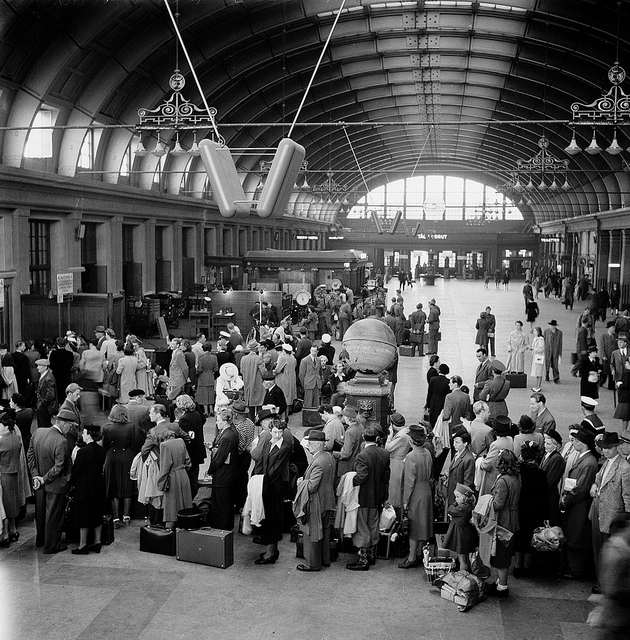

2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000189780.jpg -> data/test_imgs/000000189780.jpg
2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000183602.jpg -> data/test_imgs/000000183602.jpg
2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000523173.jpg -> data/test_imgs/000000523173.jpg
2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000143482.jpg -> data/test_imgs/000000143482.jpg
2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225392.jpg -> data/test_imgs/000000225392.jpg
2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000479125.jpg -> data/test_imgs/000000479125.jpg
2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000179926.jpg -> data/test_imgs/000000179926.jpg
2023-03-08 13:23:26 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000187435

loading annotations into memory...
Done (t=9.46s)
creating index...
index created!


100%|██████████| 345965/345965 [00:02<00:00, 143958.13it/s]
2023-03-08 13:23:47 suspicion __main__[3180558] INFO Skipped 104710 hallucinations or removals
2023-03-08 13:23:47 suspicion __main__[3180558] INFO Skipped 107645 annotations with small nr of keypoints


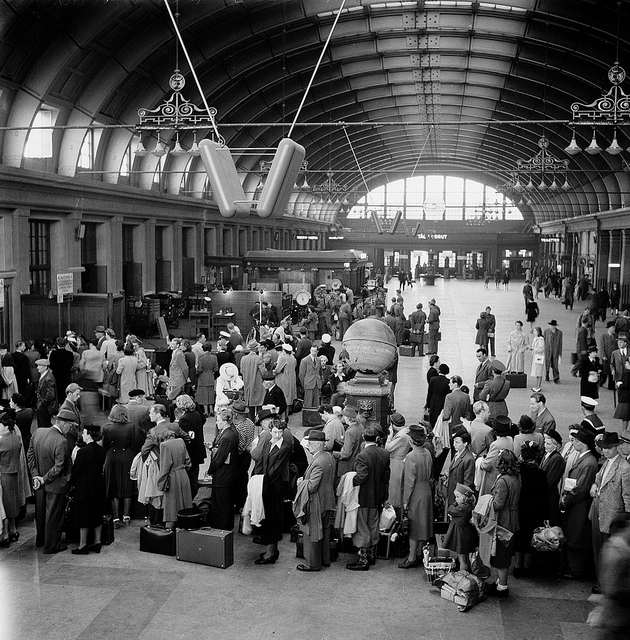

2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000189780.jpg -> data/test_imgs/000000189780.jpg
2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000523173.jpg -> data/test_imgs/000000523173.jpg
2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000183602.jpg -> data/test_imgs/000000183602.jpg
2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000225392.jpg -> data/test_imgs/000000225392.jpg
2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000479125.jpg -> data/test_imgs/000000479125.jpg
2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000187435.jpg -> data/test_imgs/000000187435.jpg
2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000337976.jpg -> data/test_imgs/000000337976.jpg
2023-03-08 13:23:48 suspicion __main__[3180558] INFO Copy data/coco/train2017/000000179926

In [11]:
i = 0
while True:
    i+=1
    iteration = Iteration(i)
    if not iteration.merged_results_path('train').exists():
        break
    results = find_most_different_annotations(coco_orig, iteration, 10)
    copy_annotation_matches_to_path(Path('./data/test_imgs/'), results)
    

2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000189780.jpg -> data/test_imgs/000000189780.jpg
2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000337976.jpg -> data/test_imgs/000000337976.jpg
2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000225645.jpg -> data/test_imgs/000000225645.jpg
2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000225392.jpg -> data/test_imgs/000000225392.jpg
2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000008285.jpg -> data/test_imgs/000000008285.jpg
2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000195826.jpg -> data/test_imgs/000000195826.jpg
2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000179926.jpg -> data/test_imgs/000000179926.jpg
2023-03-08 12:23:41 suspicion __main__[3131215] INFO Copy data/coco/train2017/000000045537

In [ ]:
def main():
    # original_path = Path('data/coco/annotations/person_keypoints_train2017.json')
    
    
    # tmp_name = Path('/tmp/orig.pcl')
    # if tmp_name.exists():
    #     logger.info(f"load pickle {tmp_name}")
    #     with tmp_name.open('rb') as fp:
    #         original_annotations = pickle.load(fp)
    # else:
    #     logger.info(f"load {original_path}")
    #     with original_path.open('r') as fp:
    #         original_data = json.load(fp)

    #     logger.info(f"\tparse keypoints to numpy")

    #     original_annotations = {}
    #     for ann in tqdm.tqdm(original_data['annotations']):
    #         if ann['image_id'] not in original_annotations:
    #             original_annotations[ann['image_id']] = []
    #         ann['keypoints'] = np.array(ann['keypoints'])

    #         original_annotations[ann['image_id']].append(ann)

    #     with tmp_name.open('wb') as fp:
    #         pickle.dump(original_annotations, fp)
    
    i = 0
    annotation_losses = {}
    while True:
        i+=1
        # iteration = Iteration(i)
        # annotation_losses[iteration.nr] = []
        # path = iteration.merged_results_path('train')
        # logger.info(f"load {path}")
        # with path.open('r') as fp:
        #     iter_data = json.load(fp)

        # iteration_annotations = {}
        # matched_annotations = []
        # for ann in tqdm.tqdm(iter_data['annotations']):
        #     # assert iter_data['images'][ann['image_id']]['file_name'] ==  original_data['images'][ann['image_id']]['file_name']
        #     if ann['image_id'] not in iteration_annotations:
        #         iteration_annotations[ann['image_id']] = []
            
        #     iteration_annotations[ann['image_id']].append(ann)

        # for image_id, annotations in tqdm.tqdm(original_annotations.items()):
        #     if image_id not in iteration_annotations:
        #         img_annotations = []
        #     else:
        #         img_annotations = iteration_annotations[image_id]

        #     matched_annotations.extend([(image_id, ann1, ann2) for ann1, ann2 in match_annotations(annotations, img_annotations)])
        
        # # clear some memory
        # iteration_annotations = None

        # match_losses = []
        # skipped = 0
        # for image_id, ann1, ann2 in tqdm.tqdm(matched_annotations):
        #     if ann1 is None or ann2 is None:
        #         # todo: we later want to store these somewhere else
        #         logger.debug(f'skipping hallucination or removal in {image_id}')
        #         skipped+=1
        #         continue

        #     match_losses.append((image_id, diff_keypoints(ann1, ann2), ann1, ann2))
        
        logger.info(f'Skipped {skipped} hallucinations or removals')

        largest = heapq.nlargest(20, match_losses, key=lambda ml: ml[1])
        with open(f'diffs_iter{iteration.nr}.json', 'w') as fp:
            for j, large in enumerate(largest):
                largest[j][2]['keypoints'] = large[2]['keypoints'].tolist() if type(large[2]['keypoints']) == np.ndarray else large[2]['keypoints']
                largest[j][3]['keypoints'] = large[3]['keypoints'].tolist() if type(large[3]['keypoints']) == np.ndarray else large[3]['keypoints']

            json.dump(largest, fp)
        
        filenames = [(iter_data['images'][img_id], diff, ann1, ann2) for img_id, diff, ann1, ann2 in largest]
        with open(f'diffs_iter{iteration.nr}_files.json', 'w') as fp:

            for j, fn in enumerate(filenames):
                filenames[j][2]['keypoints'] = fn[2]['keypoints'].tolist()
                filenames[j][3]['keypoints'] = fn[3]['keypoints'].tolist()
            json.dump(filenames, fp)
